# Logistic Regression
### Natalie Hunt


## Standards/Objectives

 * Place logistic regression in the taxonomy of ML algorithms
 * Explain the key differences and similarities between logistic and linear regression.
 * Fit and interpret a logistic regression model in scikit-learn
 * Interpret the coefficients of logistic regression, using odds ratio
 * Explain ROC curves

## Logistic regression as a model

Logistic regression is a supervised-learning parametric classification model. It's generally the first thing you try when building a classifier, and is actually used in some production environments.

Advantages:

 * Fast
 * Simple (few hyperparameters)
 * Interpretable
 * Provides probability
 
Disadvantages

 * Requires feature engineering to capture non-linear relationships
 * Doesn't work for p > n


## Comparison to linear regression

Recall that with linear regression we assume the data follows the form

$$\begin{align}
Y & = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + ... \beta_p X_p + \epsilon \\
  & = X \beta + \epsilon
\end{align}$$

where again

$$\epsilon \sim N(0, \sigma)$$

Alternatively, we could say
$$Y \sim N(X \beta, \sigma)$$

From there, we want to find the values for $\beta$ that are the most likely to produce the data. The MLE estimate gives us ordinary least squares.

With logistic regression we assume $Y$ follows a Bernoulli distribution, where $p$ is given by

$$p = f(\beta_0 + \beta_1 X_1 + \beta_2 X_2 + ... \beta_p X_p)$$

so

$$Y \sim Bernoulli(f(X \beta))$$

We want a function with values from 0 to 1. A good candidate is the logistic function

$$f(x) = \frac{1}{1+e^{-x}}$$

We could have used other similar functions like the inverse tangent or the probit function, but this has better properties.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as scs
import scipy
from sklearn.linear_model import LogisticRegression
import itertools

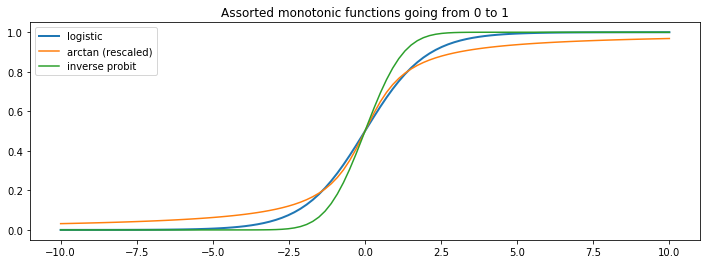

In [2]:
fig, ax = plt.subplots(figsize=(12,4))
xpts = np.linspace(-10, 10, 100)
ax.plot(xpts, 1/(1+np.exp(-xpts)), label='logistic', lw=2)
ax.plot(xpts, np.arctan(xpts)/np.pi + 0.5, label='arctan (rescaled)')
ax.plot(xpts, (1+scipy.special.erf(xpts/np.sqrt(2)))/2, label='inverse probit')
ax.legend(loc='best')
ax.set_title("Assorted monotonic functions going from 0 to 1")

Again, we solve with maximum-likelihood estimation. Note that there isn't a close-form solution here; the compute has to solve numerically using some form of gradiant descent (tomorrow's lecture).

## Example (with fake data)

We'll generate fake data that matches the distribution exactly and try to recover the parameters.

In [3]:
npts = 100
beta0 = 0.0
beta1 = 0.5

X = scs.uniform(-9, 18).rvs(npts).reshape(npts,1)
# the expit function is the same as the logistic function
y = scs.bernoulli(scipy.special.expit(beta0 + beta1*X[:,0])).rvs(npts)

We graph the data; the vertical line shows the decision boundary where the probability is 0.5.

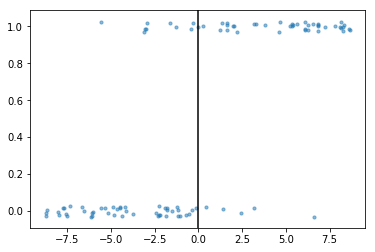

In [4]:
jitter = scs.uniform(-0.03,0.06).rvs(npts)
fig, ax = plt.subplots()
ax.scatter(X[:,0], y + jitter, s=10, alpha=0.5)
ax.axvline(-beta0/beta1, color='black')

In [5]:
# set C large to suppress regularization
model = LogisticRegression(C=1000)
model.fit(X, y)
beta0hat = model.intercept_[0]
beta1hat = model.coef_[0][0]
print "beta0 =    {0:8.3f} beta1 =    {1:8.3f}".format(beta0, beta1)
print "beta0hat = {0:8.3f} beta1hat = {1:8.3f}".format(beta0hat, beta1hat)

beta0 =       0.000 beta1 =       0.500
beta0hat =    0.022 beta1hat =    0.485


Let's draw the curve we fitted on the data, along with the actual decision boundary.

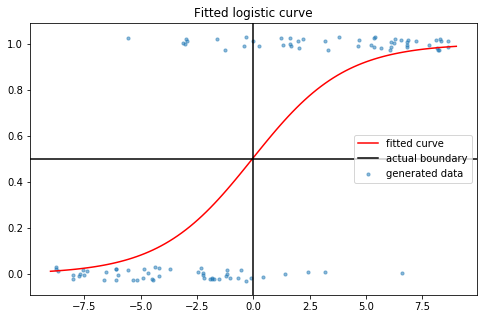

In [6]:
xpts = np.linspace(-9, 9, 100)
ypts = 1/(1 + np.exp(-(beta0hat + beta1hat * xpts)))

jitter = scs.uniform(-0.03,0.06).rvs(npts)
fig,ax = plt.subplots(figsize=(8,5))
ax.scatter(X[:,0], y + jitter, s=10, alpha=0.5, label="generated data")
ax.plot(xpts, ypts, 'r', label='fitted curve')
ax.axhline(0.5, color='black')
ax.axvline(-beta0/beta1, color='black', label='actual boundary')
ax.set_title("Fitted logistic curve")
ax.legend(loc='center right')

## Log-odds ratio

The odds ratio is the ratio of the positive to the negative case, i.e., 

$$OR = \frac{P(y=1)}{1-P(y=1)}$$

E.g., something with a 75% chance of happening has 3:1 odds. If these are given by the logistic expression above,

$$\begin{align}
OR &= \frac{P(y=1)}{1-P(y=1)} \\
   &= \frac{\frac{1}{1+e^{-X\beta}}}{1-\frac{1}{1+e^{-X\beta}}} \\
   &= \frac{1}{e^{-X\beta}} \\
   &= e^{X\beta}
\end{align}
$$
so
$$log(OR) = X\beta$$

So if you increase $x_i$ by 1, you increase $log(OR)$ by $\beta_i$.



## Decision boundary

The **decision boundary** is the surface in feature space at which the probability is 0.5, so

$$\beta_0 + \beta_1 X_1 + \beta_2 X_2 = 0$$

so

$$ X_2 = \frac{-\beta_0}{\beta_2} + \frac{-\beta_1}{\beta_2}X_1 $$

but you could use a different ratio. More broadly, for decision boundary $\theta$,

$$\theta = \frac{1}{1-e^{-x}}$$

$$\theta - \theta e^{-x} = 1$$

$$1 - \theta = \theta e^{-x}$$
$$x = -\ln{(\frac{1}{\theta} - 1)}$$


In [7]:
def generate_2d_dist(npts, mu, sd):
    '''generate 2-d distribution of points from 2-tuples mu and sd,
    returning npts-by-2 numpy array'''
    X = np.zeros((npts, 2))
    for i in [0,1]:
        X[:,i] = scs.norm(mu[i], sd[i]).rvs(npts)
    return X
    
def generate_classes(nptses, mus, sds):

    X = np.zeros((0,2))
    y = np.zeros((0,))
    
    for i,npts, mu, sd in zip(itertools.count(), nptses, mus, sds):
        X = np.concatenate([X, generate_2d_dist(npts, mu, sd)])
        y = np.concatenate([y, np.ones(npts)*i])
    return X, y
        

In [8]:
def decision_boundary_x2(x, b0, b1, b2, threshold):
    return (-x*b1 - b0 -np.log(1/threshold - 1))/b2

def plot_decision_boundary(X, y, model):
    '''plot 2-d array of points, with decision boundaries'''
    
    fig, ax = plt.subplots(figsize=(8,8))
    ax.scatter(X[:,0], X[:,1], color=np.where(y, 'g', 'b'), alpha=0.5, s=2)
    ax.axis('equal')

    xmin, xmax = X[:,0].min(), X[:,0].max()
    xrng = np.array([2*xmin-xmax, 2*xmax-xmin])

    ylim = ax.get_ylim()
    xlim = ax.get_xlim()

    beta0 = model.intercept_
    beta1, beta2 = model.coef_[0]
    
    for threshold, ls in zip([.1, .25, .5, .75, .9], [':', '--', '-', '--', ':']):
        ax.plot(xrng,
                decision_boundary_x2(xrng, beta0, beta1, beta2, threshold),
                color='r',
                ls=ls,
                label="threshold={}".format(threshold))
    ax.legend()
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

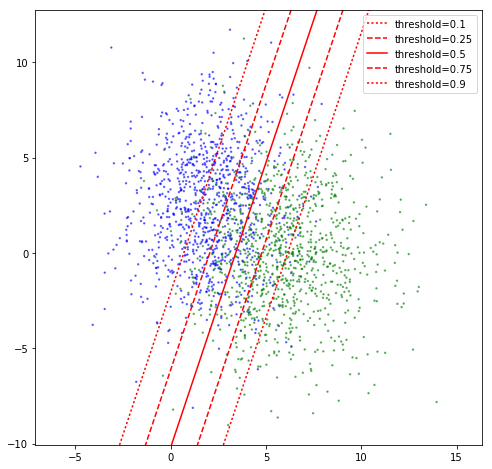

In [9]:
X, y = generate_classes((1000,1000),
                       ((2.0,2.5),(6.0,0.0)),
                       ((2.0,3.0),(2.5,3.0)))

model = LogisticRegression(C=1000)
model.fit(X, y)

plot_decision_boundary(X, y, model)

## Evaluating a binary classifier


## Confusion matrix

A [Confusion Matrix](https://en.wikipedia.org/wiki/Confusion_matrix) gives the count of instances based on the actual and predicted values of the target. For a binary classifier it looks like

|                    |Predicted positive|Predicted negative |
|--------------------|------------------|---------------|
| **Actual positive**| true positive    | false negative|
| **Actual negative**| false positive   | true negative |


*True* and *false* refer to whether you are correct.

*Positive* and *negative* refer to the **predicted** result.

A *type-I error* is a false positive (which I remember because that phrase is more common than false negative).

Accuracy $= \frac{TP+TN}{TP+TN+FP+FN}$

Sensitivity = Recall = TPR $= \frac{TP}{TP+FN}$

FPR $= \frac{FP}{TN+FP}$

Specificity $= \frac{TN}{TN+FP}$

Precision = PPV $= \frac{TP}{TP+FP}$

NPV $= \frac{TN}{TN+FN}$

![confusion matrix](Confusion_Matrix.png)

#### F-score

$F_\beta$ evaluates a test assuming that recall is $\beta$ times as important as precision; it's a weighted harmonic mean of the two.

$$F_\beta = (1+\beta^2) \frac{\text{precision} \cdot \text{recall}}{\beta^2\text{precision} + \text{recall} } $$


$$F_1 = 2 \frac{\text{precision} \cdot \text{recall}}{\text{precision} + \text{recall} }  = \frac{1}{\frac{\frac{1}{\text{precision}} + \frac{1}{\text{recall}}}{2}}$$

## ROC Curves

Any decent classification model will provide the probabilities that a data point is in one class or another. To visualize the overally goodness of a model we use a Receiver Operator Characteristic curve, which shows the TPR (a.k.a Sensitivity) and FPR (a.k.a. 1-Specificity) for various thresholds.

Any alternative is the Precision-recall curve, which is more appropriate when you're more interested in the positive class.

Models can be compared by the Area Under the Curve (AUC) of either graph.

In [10]:
def calculate_threshold_values(prob, y):
    '''
    Build dataframe of the various confusion-matrix ratios by threshold
    from a list of predicted probabilities and actual y values
    '''
    df = pd.DataFrame({'prob': prob, 'y': y})
    df.sort_values('prob', inplace=True)
    
    actual_p = df.y.sum()
    actual_n = df.shape[0] - df.y.sum()

    df['tn'] = (df.y == 0).cumsum()
    df['fn'] = df.y.cumsum()
    df['fp'] = actual_n - df.tn
    df['tp'] = actual_p - df.fn

    df['fpr'] = df.fp/(df.fp + df.tn)
    df['tpr'] = df.tp/(df.tp + df.fn)
    df['precision'] = df.tp/(df.tp + df.fp)
    df = df.reset_index(drop=True)
    return df
    
def plot_roc(ax, df):
    
    ax.plot([1]+list(df.fpr), [1]+list(df.tpr))
    ax.plot([0,1],[0,1], 'k')
    ax.set_xlabel("fpr")
    ax.set_ylabel("tpr")
    ax.set_title('ROC')
    
def plot_precision_recall(ax, df):
    ax.plot(df.tpr,df.precision)
    #ax.plot([0,1],[0,1], 'k')
    ax.set_xlabel("recall")
    ax.set_ylabel("precision")
    ax.set_title('Precision/Recall')
    ax.plot([0,1],[df.precision[0],df.precision[0]], 'k')
    ax.set_xlim(xmin=0,xmax=1)
    ax.set_ylim(ymin=0,ymax=1)

In [11]:
X, y = generate_classes((10000,10000),
                       ((2.0,2.5),(6.0,0.0)),
                       ((2.0,3.0),(2.5,3.0)))

model = LogisticRegression(C=1000)
model.fit(X, y)
#plot_decision_boundary(X, y, model)

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

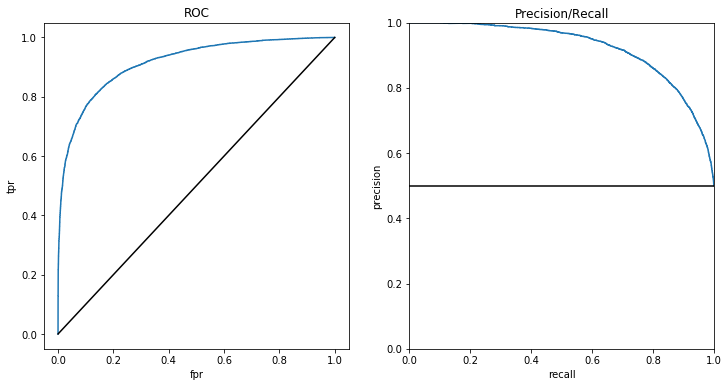

In [12]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12,6))
df = calculate_threshold_values(model.predict_proba(X)[:,1], y)
plot_roc(ax0, df)
plot_precision_recall(ax1, df)